In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import hmean, norm

In [2]:
from nltk import word_tokenize
from collections import Counter
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize

In [3]:
#from pylab import arange, argsort, loglog, title, xlabel, ylabel, grid, logspace, log10
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from statistics import harmonic_mean

In [5]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper
from bokeh.models import HoverTool

In [6]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [69]:
#data= load_dataset("imdb", split= "test")
data= load_dataset("oscar", "unshuffled_deduplicated_en", split = "train", streaming= True)
#data= load_dataset("poem_sentiment","plain_text", split = "test")
#data = load_dataset("c4", "en", split= "train", streaming = True)
#data_head = data.take(10)

In [70]:
#For streaming data
data_head = data.take(5)

In [ ]:
datadf = pd.json_normalize(data)

#### Looking at the top rows

In [ ]:
datadf.head()

#### Getting more information

In [62]:
datadf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          104 non-null    int64 
 1   verse_text  104 non-null    object
 2   label       104 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.6+ KB


#### Checking for missing values

In [48]:
datadf[datadf.isnull().any(axis=1)].head()

,id,verse_text,label


In [12]:
np.sum(datadf.isnull().any(axis=1))

0

#### Count vocab size + frequencies

In [49]:
#needed to modify the minimum token length : https://stackoverflow.com/questions/33260505/countvectorizer-ignoring-i
cvec = CountVectorizer(token_pattern=u"(?u)\\b\\w+\\b")
cvec.fit(datadf.verse_text)

CountVectorizer(token_pattern='(?u)\\b\\w+\\b')

In [50]:
len(cvec.get_feature_names())

2270

In [51]:
document_matrix = cvec.transform(datadf.verse_text)

In [16]:
#Code from https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-2-333514854913

In [52]:
datadf.shape[0]

892

In [53]:
%%time
batches = np.linspace(0,datadf.shape[0],100).astype(int)
i=0
tf = []
while i < len(batches)-1:
    batch_result = np.sum(document_matrix[batches[i]:batches[i+1]].toarray(),axis=0)
    tf.append(batch_result)
    if (i % 10 == 0) | (i == len(batches)-2):
        print(batches[i+1],"entries' term frequency calculated")
    i += 1

9 entries' term frequency calculated
99 entries' term frequency calculated
189 entries' term frequency calculated
279 entries' term frequency calculated
369 entries' term frequency calculated
459 entries' term frequency calculated
549 entries' term frequency calculated
639 entries' term frequency calculated
729 entries' term frequency calculated
819 entries' term frequency calculated
892 entries' term frequency calculated
CPU times: user 22.2 ms, sys: 520 µs, total: 22.7 ms
Wall time: 19.5 ms


In [54]:
term_freq_df = pd.DataFrame([np.sum(tf,axis=0)],columns=cvec.get_feature_names()).transpose()
term_freq_df.columns=['total']
term_freq_df.head()

,total
_channing_,1
_quart,1
_she_,1
_you_,1
a,109


In [55]:
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,total
the,402
and,258
of,144
to,115
a,109
in,90
i,85
s,77
that,68
with,64


#### Zipf's law calculations

##### I tried running it on all tokens, but it makes my computer crash...

Text(0.5, 1.0, "Top 500 tokens in IMDB reviews, with Zipf's law in dotted red")

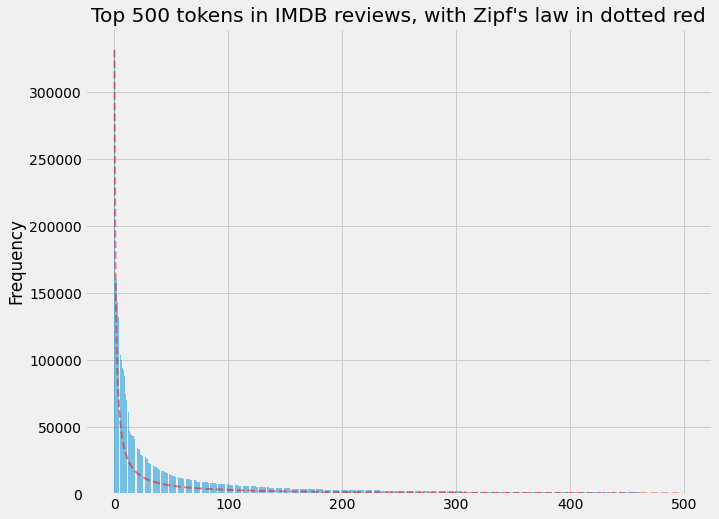

In [29]:
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title("Top 500 tokens in IMDB reviews, with Zipf's law in dotted red")

### Checking which words do not respect Zipf's law

In [30]:
terms = pd.DataFrame(term_freq_df.sort_values(by='total', ascending=False)['total'][:500])
terms['zipf'] = [int(z) for z in expected_zipf]

In [31]:
terms.head()

,total,zipf
the,331244,331244
and,160301,165622
a,159847,110414
of,143546,82811
to,132400,66248


In [32]:
def check_Zipf(count,zipf):
        return((count-zipf)/zipf * 100)

In [33]:
terms['difference'] = terms.apply(lambda x: check_Zipf(x['total'], x['zipf']), axis=1)

In [34]:
terms['difference'].describe()

count    500.000000
mean     101.911027
std       15.582445
min       -3.212737
25%       91.834282
50%       97.364337
75%      110.788305
max      165.496317
Name: difference, dtype: float64

In [36]:
terms.loc[(terms['difference'] >=100)].count()

total         203
zipf          203
difference    203
dtype: int64

In [35]:
terms.loc[(terms['difference'] >=100)].head(10)

,total,zipf,difference
br,100080,47320,111.496196
it,94390,41405,127.967637
in,92805,36804,152.160091
i,87943,33124,165.496317
this,74995,30113,149.045263
that,70593,27603,155.743941
s,61406,25480,140.996860
was,47399,23660,100.333897
as,44815,22082,102.948103
movie,43924,20702,112.172737


So here we can say that 203/500 of the most common words are significantly (?) different from their predicted frequencies according to Zipf's law?

### Checking open versus closed class words

In [37]:
wordlist=open('../resources/closed_EN.txt', 'r').readlines()

In [38]:
closedlist=[]
for l in wordlist:
    closedlist= closedlist + (l.split())
print(len(closedlist))

312


In [39]:
terms.shape

(500, 3)

In [40]:
terms.sort_values(by='difference', ascending=True).head(10)

,total,zipf,difference
and,160301,165622,-3.212737
the,331244,331244,0.000000
a,159847,110414,44.770591
of,143546,82811,73.341706
fine,1221,665,83.609023
group,1237,673,83.803863
brilliant,1217,662,83.836858
act,1228,667,84.107946
writing,1221,663,84.162896
heart,1236,671,84.202683


In [41]:
terms.loc[(terms.index =='an')]

,total,zipf,difference
an,21422,9464,126.352494


In [42]:
closedclass= terms[terms.index.isin(closedlist)]
closedclass.shape

(142, 3)

In [43]:
closedclass.loc[(closedclass['difference'] >=100)].sort_values(by='difference', ascending=False).head(10)

,total,zipf,difference
that,70593,27603,155.743941
in,92805,36804,152.160091
this,74995,30113,149.045263
be,26426,11041,139.344262
on,33855,14401,135.087841
but,40931,17433,134.790340
one,26808,11422,134.704955
for,43126,18402,134.354961
like,19891,8493,134.204639
what,16071,6900,132.913043


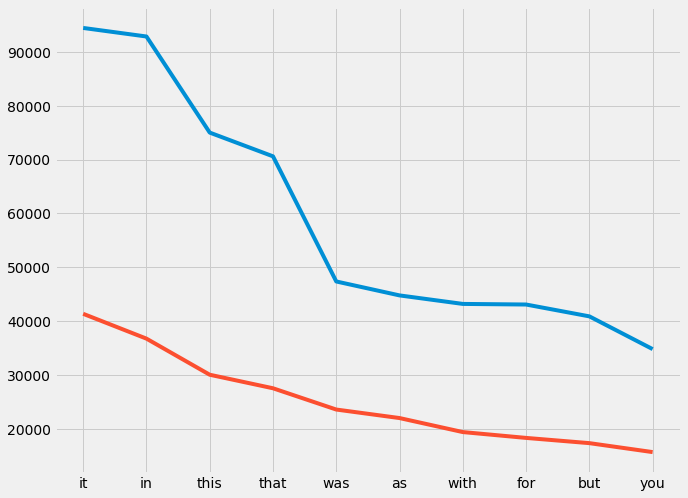

In [44]:
plt.figure(figsize=(10,8))
plt.plot(closedclass[['total','zipf']].loc[(closedclass['difference'] >=100)].sort_values(by='total', ascending=False).head(10))

In [45]:
openclass= terms[~terms.index.isin(closedlist)]
openclass.shape

(358, 3)

In [46]:
openclass['difference'].describe()

count    358.000000
mean      98.238414
std       10.885537
min       83.609023
25%       91.373872
50%       95.692489
75%      101.108615
max      165.496317
Name: difference, dtype: float64

In [47]:
openclass.loc[(openclass['difference'] >=100)].sort_values(by='total', ascending=False).head(10)

,total,zipf,difference
br,100080,47320,111.496196
i,87943,33124,165.496317
s,61406,25480,140.996860
movie,43924,20702,112.172737
film,39546,16562,138.775510
t,33890,15056,125.092986
just,17410,7886,120.770987
good,14606,6624,120.501208
very,13660,6134,122.693186
time,12383,5614,120.573566


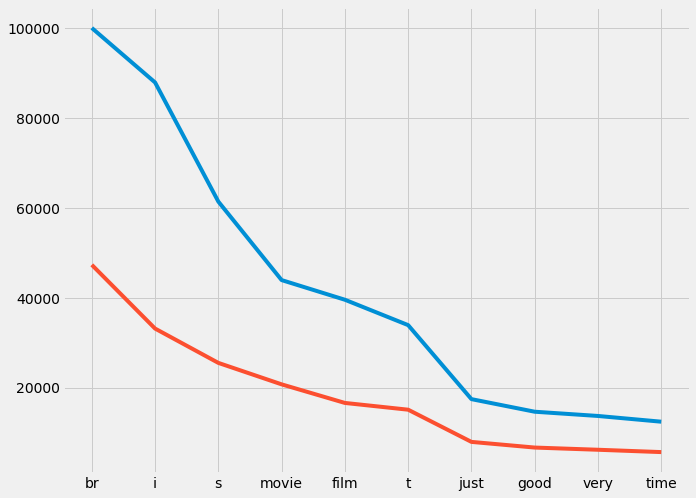

In [48]:
plt.figure(figsize=(10,8))
plt.plot(openclass[['total','zipf']].loc[(openclass['difference'] >=100)].sort_values(by='total', ascending=False).head(10))